# Directed Independent Research: Domestic Ideology and UN Alignment (1992–2020)

**Author:** Hieu Tran  
**Last Updated:** October 26, 2025

---

## Overview
This notebook explores the relationship between domestic political ideology and foreign policy alignment in United Nations General Assembly (UNGA) voting from 1992 to 2020.  
It uses machine learning—specifically a `RandomForestRegressor`—to model how domestic political factors, such as executive ideology and institutional checks, predict countries’ UNGA ideal point estimates.

---

## Objectives
- Load a preprocessed dataset containing:
  - **Database of Political Institutions (DPI)**: Executive ideology, institutional checks, election indicators  
  - **UNGA Ideal Points**: Quantified foreign policy alignment scores  
- Train a `RandomForestRegressor` to predict UNGA ideal points (`idealpointfp`) using domestic political variables  
- Evaluate model performance on test data (2016–2020), trained on 1992–2015  
- Visualize feature importances to identify which domestic factors most influence foreign policy alignment  

---

## Data Inputs
- **File:** `dpi2020_mod.csv`  
- **Path:** `/data`  
- **Description:** Contains country-year observations for advanced democracies, including executive ideology (`execrlc`), institutional checks (`checks`), and corresponding UNGA ideal point estimates (`idealpointfp`).

---

## Dependencies
- Python ≥ 3.10  
- pandas, scikit-learn, matplotlib  

---

## Notes
This notebook was developed as part of a CIEE Directed Independent Research project in Berlin, Germany, examining whether domestic political changes predict measurable shifts in international behavior.


## 1. Project Setup

This notebook analyzes whether domestic political changes predict shifts in UN General Assembly (UNGA) alignment.  
We begin by importing libraries, setting paths, and defining configuration variables.


In [1]:

import os, math
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:

CSV_PATH = "../data/dpi2020_mod.csv"

START_YEAR = 1992
END_YEAR   = 2020

TRAIN_END  = 2015      # inclusive
TEST_START = 2016      # inclusive


## 2. Load Dataset and Initial Cleaning

We load the preprocessed dataset (`dpi2020_mod.csv`), which includes both domestic political indicators  
(from the Database of Political Institutions) and UNGA ideal points.  
We then clean coding artifacts such as `0` or `-999` where they represent missing data.


In [3]:

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

required = ["country","year","execrlc","checks","idealpointfp"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Filter by year
df = df[(df["year"] >= START_YEAR) & (df["year"] <= END_YEAR)].copy()

# Handle missing data
for col in ["execrlc", "system"]:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# Preview (first 20 datapoints)
preview_cols = [c for c in ["country","year","execrlc","checks","system","legelec","exelec","idealpointfp"] if c in df.columns]

print(df[preview_cols].head(20))


    country  year  execrlc  checks  system  legelec  exelec  idealpointfp
0   Albania  1992      1.0     2.0       1        1       0      0.978085
1   Albania  1993      3.0     2.0       1        0       0      0.945894
2   Albania  1994      3.0     2.0       1        0       0      1.054056
3   Albania  1995      3.0     2.0       1        0       0      0.985947
4   Albania  1996      3.0     2.0       1        1       0      1.189963
5   Albania  1997      3.0     2.0       1        1       0      1.058038
6   Albania  1998      1.0     2.0       1        0       0      1.115533
7   Albania  1999      1.0     2.0       1        0       0      0.990348
8   Albania  2000      1.0     2.0       1        0       0      1.303230
9   Albania  2001      1.0     2.0       1        1       0      1.333558
10  Albania  2002      1.0     2.0       1        0       0      1.066275
11  Albania  2003      1.0     2.0       1        0       0      1.162230
12  Albania  2004      1.0     2.0    

## 3. Feature Engineering: Elections and Ideological Change

This section derives key analytical variables:

- **relevant_elec:** uses executive elections in presidential systems and legislative elections otherwise  
- **ideology_changed:** detects when a government’s ideology differs from the previous year  
- **years_since_elec / years_until_next_elec:** track term timing  
- **post_elec_1y–3y:** flags for the first three years after an election  
- **delta_idealpoint:** year-to-year change in UN alignment

In [4]:
# Sort
df = df.sort_values(["country", "year"]).reset_index(drop=True)

# Define relevant election based on system type
# Presidential (3) → use executive elections
# Parliamentary (1) or Assembly-Elected (2) → use legislative elections
df["relevant_elec"] = np.where(
    df["system"] == 3, df.get("exelec", 0),
    df.get("legelec", 0)
).astype(int)

# Handle missing system data gracefully
df["relevant_elec"] = df["relevant_elec"].fillna(0)

# Mark any election years
df["election_any"] = (df["relevant_elec"] == 1).astype(int)

# Lag ideology and idealpoint by one year (within each country)
df["execrlc_lag1"] = df.groupby("country")["execrlc"].shift(1)
df["idealpoint_lag1"] = df.groupby("country")["idealpointfp"].shift(1)

# Did ideology change compared to previous year?
df["ideology_changed"] = (df["execrlc"] != df["execrlc_lag1"]).astype(float)

# Identify actual election years (based on the unified variable)
df["election_year"] = df["year"].where(df["election_any"] == 1)

# Years since / until election
df["last_elec_year"] = df.groupby("country")["election_year"].ffill()
df["next_elec_year"] = df.groupby("country")["election_year"].bfill()

df["years_since_elec"] = df["year"] - df["last_elec_year"]
df["years_until_next_elec"] = df["next_elec_year"] - df["year"]

# Post-election dummy variables for 1–3 years after
for k in [1, 2, 3]:
    df[f"post_elec_{k}y"] = ((df["years_since_elec"] >= 1) & (df["years_since_elec"] <= k)).astype(int)

# (optional) make the target the change in ideal point from the previous year
df["delta_idealpoint"] = df["idealpointfp"] - df["idealpoint_lag1"]


## 4. Prepare Features and Target
After feature engineering, we now build the feature matrix (`X`) and target variable (`y`).  
If `USE_DELTA` is set to `True`, we predict *changes* in UN alignment; otherwise, we predict the alignment *level* itself.

In [5]:
USE_DELTA = False  # Set True to predict delta_idealpoint

if USE_DELTA:
    df = df.dropna(subset=["delta_idealpoint"]).copy()

df = df.reset_index(drop=True)

## 5. Build Feature Matrix and Target Vector
We include core domestic political variables (ideology, checks, system) and our election-related features (years since/until election, post-election windows, etc.).


In [6]:
# Build X and y from the resulting df
feature_cols = [
    "execrlc","checks","system",
    "ideology_changed","years_since_elec","years_until_next_elec",
    "post_elec_1y","post_elec_2y","post_elec_3y","year"
]
X = df[feature_cols].astype(float).copy()
y = (df["delta_idealpoint"] if USE_DELTA else df["idealpointfp"]).astype(float).copy()

## 6. Split Train and Test Sets
We split the dataset by year (train ≤ 2015, test ≥ 2016) to simulate out-of-sample prediction.


In [7]:
train_mask = (df["year"] <= TRAIN_END)
test_mask  = (df["year"] >= TEST_START)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]


print(len(df), X.shape, y.shape)
print("Train/Test:", X_train.shape, X_test.shape)

# Save modeling frames
X_train.to_csv("../data/X_train_single.csv", index=False)
y_train.to_csv("../data/y_train_single.csv", index=False)
X_test.to_csv("../data/X_test_single.csv", index=False)
y_test.to_csv("../data/y_test_single.csv", index=False)


841 (841, 10) (841,)
Train/Test: (696, 10) (145, 10)


## 8. Train Random Forest Model

We use a `RandomForestRegressor` to capture nonlinear relationships between domestic factors  
and UNGA alignment.  The ensemble approach helps reduce overfitting and interpret variable importance.


In [8]:
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


,n_estimators,600
,criterion,'squared_error'
,max_depth,None
,min_samples_split,4
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 9. Evaluate Model Performance

We assess model accuracy using Root Mean Squared Error (RMSE) and R² on the test set.  
Lower RMSE and higher R² indicate stronger predictive power.

In [9]:
y_pred = rf.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2 : {r2:.4f}")

Test RMSE: 0.7111
Test R^2 : -0.0767


In [ ]:
# Save predictions
pred_df = df.loc[test_mask, ["country","year"]].copy()
pred_df["y_true"] = y_test.values
pred_df["y_pred"] = y_pred
pred_df.to_csv("../data/test_predictions_single.csv", index=False)

## 10. Feature Importance Visualization

We visualize which features contributed most to the model’s predictive accuracy.  
This helps interpret the relative influence of ideology, institutional factors, and election timing.

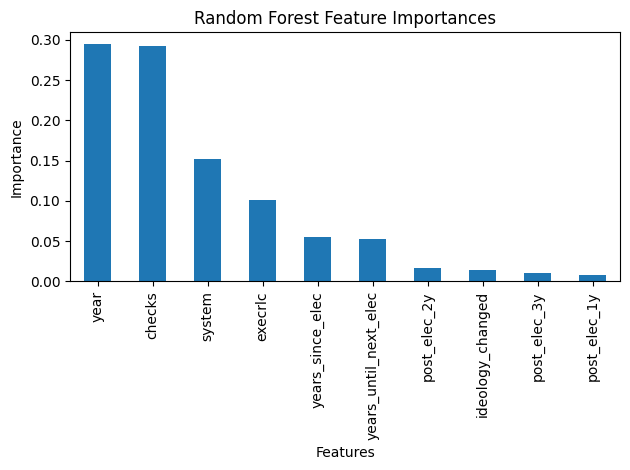

In [10]:
# Feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ax = importances.plot(kind="bar")
ax.set_title("Random Forest Feature Importances")
ax.set_xlabel("Features")
ax.set_ylabel("Importance")
plt.tight_layout()
plt.show()